# 2D+ MOT Simulation  
Before we move onto simulating our system, let's compare with DOI: 10.1103/PhysRevA.74.023406.  
Physical Dimensions:  
1. glass cell: 16.4cm $\times$ 4cm $\times$ 4cm
2. beam size(horizontal): 96 mm (waist) $\times$ 9 mm (waist) / $\sigma^+ - \sigma^-$ configuration
3. differential tube: 2mm (diameter) for 1cm long / 3mm (diameter) for 3cm long
4. beam size(vertical): 9mm (waist) / linearly polarized

For ${}^{87}Rb$, detuning is $2\Gamma$,but I should double-check the remaining parts. (may differ by measurements)

In [17]:
%load_ext autoreload
%autoreload 2
import sys, pylcp, h5py
print("python:", sys.executable)
print("pylcp type:", type(pylcp))
print("pylcp file:", getattr(pylcp, "__file__", "<no __file__ attr>"))
print("pylcp spec origin:", getattr(pylcp, "__spec__", None) and pylcp.__spec__.origin)
print("pylcp path:", getattr(pylcp, "__path__", None))

python: /opt/anaconda3/envs/MOT_workspace/bin/python
pylcp type: <class 'module'>
pylcp file: /Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp/__init__.py
pylcp spec origin: /Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp/__init__.py
pylcp path: ['/Users/ohik/Documents/MOT_workspace/pylcp_fork/pylcp']


In [11]:
# imports
import numpy as np
import pylcp
import matplotlib.pyplot as plt
import scipy.constants as cts
from jinja2 import pass_context

In [12]:
atom = pylcp.atom("87Rb")
# set unitless mass
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

804.3755599734405


## Feb 2 - 3 / 2026 Beam shapes / Add geometric constraints
While I was trying to run 2D MOT first, I realized that I have to make special beam shape (ellipse / retarding beam) and test whether pylcp actually takes this geometric information of beam for evaluating OBE, which I'm sure they can.  
To test this, I'll add elliptical and donut shapes as laserBeams and run optical molasses simulation using donut shape beam.  

~~Before we add pushing / retarding beam with geometrical constraints (differential tube hole), run 2DMOT first.  
*Assume our horizontal beam fully cover the glass cell.*~~ 

In [9]:
# set hamiltonian
det = -2
s = 1
def return_hamiltonian(Fl):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    # Check the muB unit. -> we set megneton as 1. convert when we interested physical value (force etc.)
    # How we can evaluate dipole matrix before we introduce the field? -> evaluate all polarizaiotn case
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl,(Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass = mass)
    return hamiltonian

hamiltonian = return_hamiltonian(2)



### Beam shaping test
 

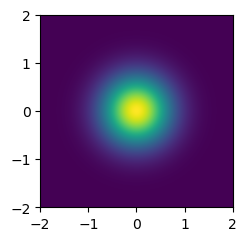

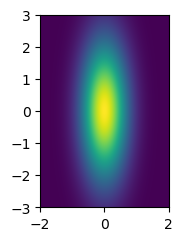

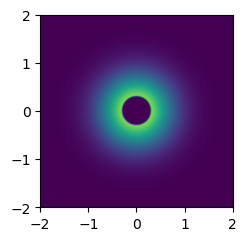

In [1]:
import pylcp.fields as fields
import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(-2, 2, 1001),
                   np.linspace(-2, 2, 1001))
Rt=np.array([X, Y, np.zeros(X.shape)])
tt=np.zeros(X.shape)

example_beam = fields.gaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wb=1)

plt.figure("Gaussian Beam", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(example_beam.intensity(R=Rt,t=tt),
           origin='lower',
           extent=(-2, 2,
                   -2, 2))
plt.clim((0, 5))
plt.set_cmap('viridis')

example_beam = fields.ellipticalgaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wa=1, wb=2)

plt.figure("Elliptical Gaussian Beam", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(example_beam.intensity(R=Rt,t=tt),
           origin='lower',
           extent=(-2, 2,
                   -3, 3))
plt.clim((0, 5))
plt.set_cmap('viridis')

example_beam = fields.donutBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2,h=0.3, wb=1)

plt.figure("Retarding Beam", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(example_beam.intensity(R=Rt,t=tt),
           origin='lower',
           extent=(-2, 2,
                   -2, 2))
plt.clim((0, 5))
plt.set_cmap('viridis')

### 2D force profile / motion evolution
Now I got every beam shapes that I need for simulating our MOT. Test this from 2D optical molasses first.  
I'll draw force profile and evolve_position with gaussian - retarding beam pairs. expected force profile and position evolution is quite obvious.

Completed in 1:38:17.                                               


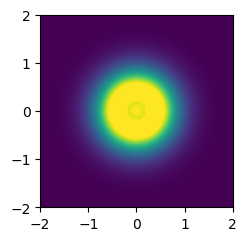

In [53]:
# 2D force profile.
# This example comes from the F=2->F'=3 1D molasses example and expand it.
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.fields as fields
import scipy.constants as cts
from pylcp.common import progressBar
import lmfit

# Define atom here
atom = pylcp.atom("87Rb")
# This is our unitless mass
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)

# beam geometries. points are unitless.

X, Y = np.meshgrid(np.linspace(-2, 2, 101),
                      np.linspace(-2, 2, 101))
Z = np.copy(X)
Rt=np.array([X, Y, Z])

example_beam1 = fields.gaussianBeam(kvec=np.array([0., 0., 1.]), pol=+1, s=5, delta=-2, wb=1)
example_beam2 = fields.donutBeam(kvec=np.array([0., 0., -1.]), pol=-1, s=5, delta =-2,h = 0.2, wb=1)
laserBeams = pylcp.laserBeams([example_beam1, example_beam2])

# Test plot for laserBeams.
plt.figure("test", figsize=(3.25, 2.5))
plt.clf()
plt.imshow(np.sum(laserBeams.intensity(R=Rt),axis=0),
           origin='lower',
           extent=(-2, 2,
                   -2, 2))
plt.clim((0, 5))
plt.set_cmap('viridis')

# Build Hamiltonian for Rb F2-F'3 transition
Hg, Bgq = pylcp.hamiltonians.singleF(F=2, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=3, gF=1/3, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(2, 3)
hamiltonian = pylcp.hamiltonian(Hg, He, Bgq, Beq, dijq, mass = mass)

# Zero magnetic field
magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

# Select solver
obe = pylcp.obe(laserBeams, magField, hamiltonian, include_mag_forces=False, transform_into_re_im=True)

# Double check why we need meshgrid
y_pts = np.linspace(-2, 2, 50)
vz_pts = np.linspace(0.05, 2, 50)

Y, Vz = np.meshgrid(y_pts,vz_pts)


obe.generate_force_profile(
    [np.zeros(np.shape(Y)), Y, np.zeros(np.shape(Y))],  
    [np.zeros(np.shape(Vz)), np.zeros(np.shape(Vz)), Vz],
    name='yz_plane_force', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
    rel=1e-8, abs=1e-10, progress_bar=True
)


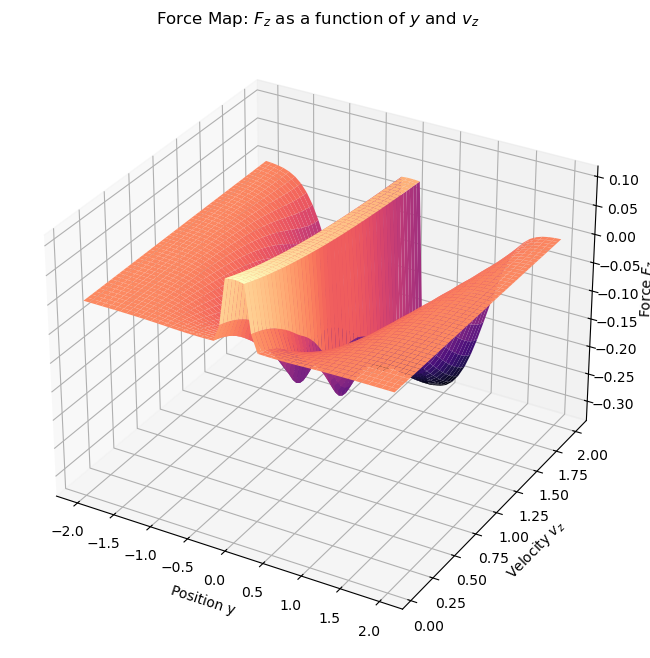

In [55]:
Fz_map = obe.profile['yz_plane_force'].F[2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Y, Vz, Fz_map, cmap='magma')

ax.set_xlabel('Position y')
ax.set_ylabel('Velocity $v_z$')
ax.set_zlabel('Force $F_z$')
plt.title('Force Map: $F_z$ as a function of $y$ and $v_z$')
plt.show()

This plot looks correct! Now save file.

In [67]:
import h5py
import datetime

now = datetime.datetime.now()
formatted_now = now.strftime("%m-%d %H:%M")
file_name = formatted_now + "force profile test"
# profile attributes:
#   R : array_like, shape(3, ...)
#   V : array_like, shape(3, ...)
#   F : array_like, shape(3, ...)
#   f_mag : array_like, shape(3, ...) / Magnetic force at position R and velocity V
#   f : dictionary of array_like / The forces due to each laser.
#   fq : dictionary of array_like / The force due to each laser and its q component.
#   Neq : array_like / Equilibrium population found
print((obe.profile['yz_plane_force'].fq.keys()))
with h5py.File(file_name + '.hdf5', 'w') as f:
    profile = f.create_group('profile')
    profile.create_dataset('R',data=obe.profile['yz_plane_force'].R)
    profile.create_dataset('V',data=obe.profile['yz_plane_force'].V)
    profile.create_dataset('F',data=obe.profile['yz_plane_force'].F)
    profile.create_dataset('f_mag',data=obe.profile['yz_plane_force'].f_mag)
    # profile.create_dataset('f', data=obe.profile['yz_plane_force'].f)
    # profile.create_dataset('fq', data=obe.profile['yz_plane_force'].fq)
    # profile.create_dataset('Neq', data=obe.profile['yz_plane_force'].Neq)


dict_keys(['g->e'])


['profile']


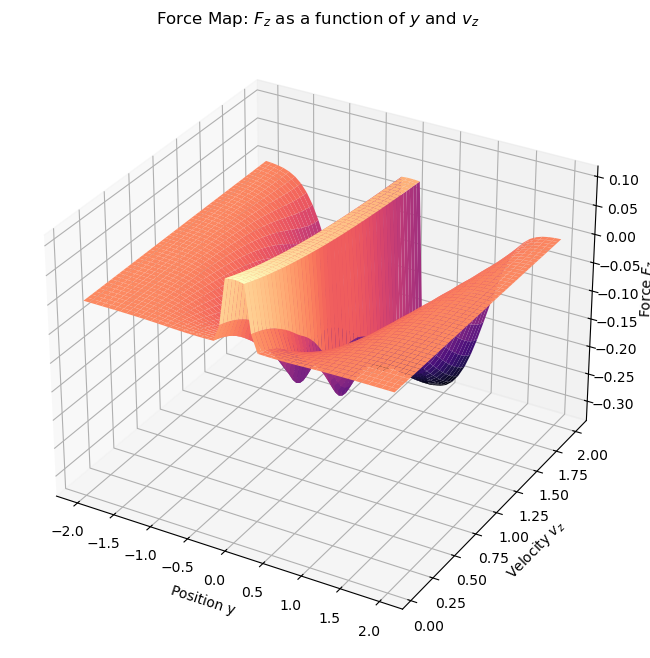

In [73]:
with h5py.File('02-03 19:51force profile test.hdf5', 'r') as f:
    print(list(f.keys()))
    profile = f['profile']
    R = profile['R']
    V = profile['V']
    F = profile['F']
    Fz_map = F[2]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(R[1], V[2], Fz_map, cmap='magma')
    
    ax.set_xlabel('Position y')
    ax.set_ylabel('Velocity $v_z$')
    ax.set_zlabel('Force $F_z$')
    plt.title('Force Map: $F_z$ as a function of $y$ and $v_z$')
    plt.show()